# Variational Classifier

A **variational quantum circuit** is a parametrized quantum algorithm $U(\vec{\theta})$, where $U(\vec{\theta})$ is a unitary operator and $\vec{\theta}$ is a vector of parameters. A **variational classifier** is a specific type of variational circuit where the parameters $\vec{\theta}$ are optimized to learn a classification function $f: D \to \{0, 1\}$, based on a train dataset (i.e., based on the behavior of $f$ on a subset of $D$). This function $f$ is used to label data from a given dataset $D$, and usually $D\subset \mathbb{R}^n$. 

The first step of a variational classifier is a **data encoding** which is a process to transform classical data into quantum states. Some examples of data encodings are the *basis encoding*, *amplitude encoding* and *angle encoding*. The second step is the application of $k$ consecutive *layers*. A *layer* is usually decomposed into two parametrized unitary operators $A(\alpha)$ and $B(\beta)$, where $A(\alpha)$ contains only single-qubit gates, and $B(\beta)$ is an entangler operator containing single-qubit and entangling gates. The most common layer is the *Strongly Entangling Layer*, which applies to each qubit an arbitrary rotation parametrized by 3 angles, and then applies CNOT gates as in Figure 1.

<figure style="text-align: center">
  <img src="images/strongly-entangling-layer.png" alt="Strongly Entangling Layer">
  <figcaption>Figure 1. A Strongly Entangling Layer in a 4-qubit circuit. Each 'Rot' gate is an arbitrary rotation parametrized by 3 angles.</figcaption>
</figure>

At the end of a variational circuit we obtain the expected value of an observable $\hat{M}$, obtaining a scalar 
$$g(\vec{\theta}) = \langle 0 | U(\vec{\theta})^\dag \hat{M} U(\vec{\theta}) | 0 \rangle.$$
Sometimes $g$ is minimized, but we could also make a post-processing to obtain another cost function that depends on $\vec{\theta}$. Later we will see which observable is suitable for a variational classifier. 

In this task, we show how to learn two classification functions with a quantum variational classifier:
1. The parity function $f: \{0, 1\}^n \to \{0,1\}$ given by $f(x)=1$ if $x$ has an uneven number of 1's, and $f(x)=0$ in another case;
2. The classification function of the well-known Iris dataset, considering only two classes of flowers.

First, we do the necessary imports.

In [1]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import NesterovMomentumOptimizer
import matplotlib.pyplot as plt

Then, we create the quantum device where the quantum circuits will be executed. In our case, we use a simulator.

In [2]:
dev = qml.device("default.qubit") # Device where the quantum circuits will be executed

## Learning the parity function

In this section we explain how to learn the parity function with only a subset of all the domain $\{0, 1\}^n$. In the code, we use $n=4$.

We use the basis encoding that maps $x\in \{0, 1\}^n$ into $|x\rangle$, e.g., $(0, 1, 0, 1)\mapsto |0101\rangle$. Also we use the strongly entangling layer for the variational circuit.

In [3]:
def layer(layer_weights: np.tensor):
    """Strongly entangling layer with parameters given by the tensor layer_weights of size (n, 3), where n is the number of qubits. 
    layer_weights[i] correspond to the 3 parameters for the arbitrary rotation applied to qubit i.

    :param layer_weights: Tensor of size (n, 3), where n is the number of qubits.
    :type layer_weights: np.tensor
    """    
    n = layer_weights.shape[0] # number of qubits
    
    # Apply an arbitrary single-qubit rotations to each qubit. Each rotation is parametrized by 3 angles
    for wire in range(n):
        qml.Rot(*layer_weights[wire], wires=wire)

    # entangling sublayer with CNOTs
    for wires in [[i, (i+1)%n] for i in range(n)]:
        qml.CNOT(wires)
        

def state_preparation(x: np.tensor):
    """Prepare the basis state |x>, where x is a vector of 0's and 1's

    :param x: Tensor of size n (number of qubits) with 0's and 1's
    :type x: np.tensor
    """    
    n = len(x)
    qml.BasisState(x, wires=range(n))

The variational quantum circuit consists of the state preparation process given by the chosen data encoding, followed by $k$ strongly entangling layers. Here we use $k=2$. At the end of the circuit, we obtain the expected value of a $Z$ measurement on the first qubit, add some *bias*, and finally take the sign of that sum to obtain a final classification (-1 or 1 instead of 0 or 1). 

In [4]:
@qml.qnode(dev) # quantum node where the quantum function (circuit) will be executed in the given device
def circuit(weights: np.tensor, x: np.tensor) -> float:
    """Variational quantum circuit that receives the parameters ``weights`` of the circuit and the classical data in vector ``x``. It returns the expected value of the Z observable on the first qubit.

    :param weights: A tensor of size (k, n, 3), where k is the number of layers of the variational circuit and n is the number of qubits. weights[i][j] are the 3 parameters of the arbitrary rotation applied
    to qubit j in the i-th layer.
    :type weights: np.tensor
    :param x: 1D tensor of size n that represents the classical data.
    :type x: np.tensor
    :return: The expected value of the Z observable on the first qubit.
    :rtype: float
    """    
    state_preparation(x) # data encoding

    for layer_weights in weights:
        layer(layer_weights) # strongly entangling layer

    return qml.expval(qml.PauliZ(0)) # expected value of a Z measurement on the first qubit

def variational_classifier(weights: np.tensor, bias: np.tensor, x: np.tensor) -> float:
    """Variational classifier that runs the quantum circuit with the given parameters (tensor ``weights`` and bias) and classical data x, and then add some bias to the result.

    :param weights: A tensor of size (k, n, 3), where k is the number of layers of the variational circuit and n is the number of qubits. weights[i][j] are the 3 parameters of the arbitrary rotation applied
    to qubit j in the i-th layer.
    :type weights: np.tensor
    :param bias: A 0-dimensional tensor (scalar) for the bias.
    :type bias: np.tensor
    :param x: Vector of classical data
    :type x: np.tensor
    :return: Output of circuit plus bias
    :rtype: float
    """    
    return circuit(weights, x) + bias

def predict(weights: np.tensor, bias: np.tensor, x: np.tensor) -> float:
    """Returns the predicted label (1 or -1) for the data vector x, depending on the sign of the variational classifier output. 

    :param weights: A tensor of size (k, n, 3), where k is the number of layers of the variational circuit and n is the number of qubits. weights[i][j] are the 3 parameters of the arbitrary rotation applied
    to qubit j in the i-th layer.
    :type weights: np.tensor
    :param bias: A 0-dimensional tensor (scalar) for the bias.
    :type bias: np.tensor
    :param x: Vector of classical data
    :type x: np.tensor
    :return: Predicted label for vector x, 1 or -1.
    :rtype: float
    """    
    return np.sign(variational_classifier(weights, bias, x))

Below is the diagram of the quantum circuit.

Initial parameters
Weights: [[[ 0.01764052  0.00400157  0.00978738]
  [ 0.02240893  0.01867558 -0.00977278]
  [ 0.00950088 -0.00151357 -0.00103219]
  [ 0.00410599  0.00144044  0.01454274]]

 [[ 0.00761038  0.00121675  0.00443863]
  [ 0.00333674  0.01494079 -0.00205158]
  [ 0.00313068 -0.00854096 -0.0255299 ]
  [ 0.00653619  0.00864436 -0.00742165]]]
Bias:  0.0

Quantum circuit diagram


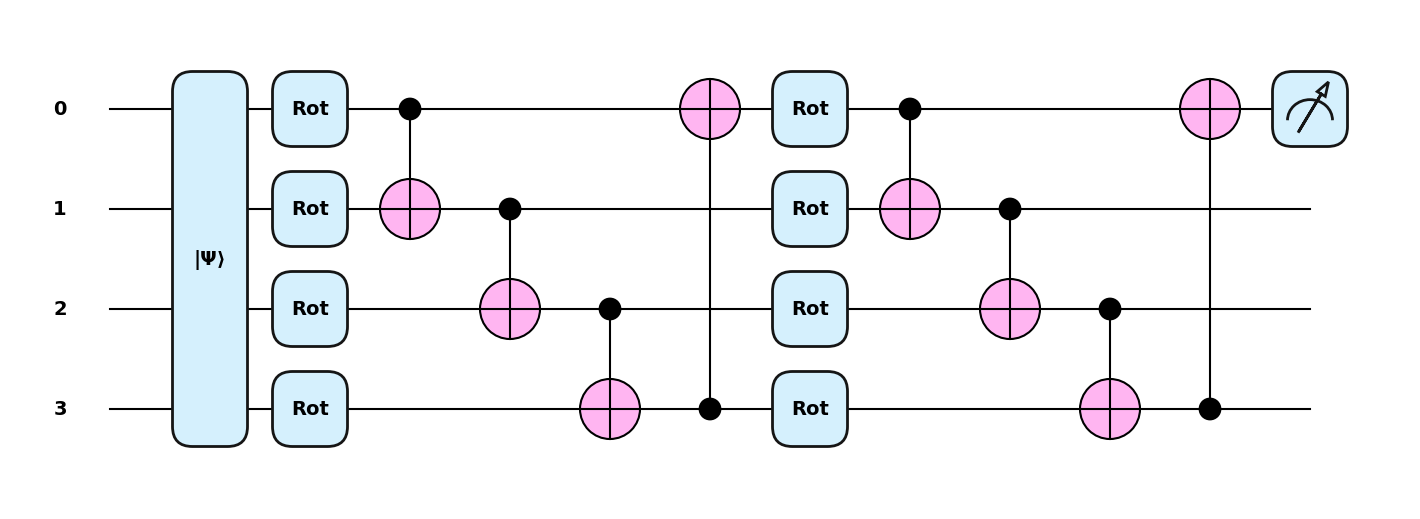

In [17]:
np.random.seed(0)
num_qubits = 4
num_layers = 2
weights_init = 0.01 * np.random.randn(num_layers, num_qubits, 3, requires_grad=True) # random initial parameters
bias_init = np.array(0.0, requires_grad=True)

print("Initial parameters")
print("Weights:", weights_init)
print("Bias: ", bias_init)

print("\nQuantum circuit diagram")
qml.draw_mpl(circuit, style="pennylane")(weights_init, [0,0,1,0])
plt.show()

To find the optimal parameters for the variational classifier that *learns* the parity function, we need to define an optimization problem. The cost function we use for this optimization problem is the squared loss, which is the sum of the squared differences between the variational classifier outputs and the real labels for the training dataset.

In [5]:
def square_loss(labels: np.tensor, predictions: np.tensor) -> float:  
    # Squared loss: sum of the squared differences between the labels and the predictions
    
    # We use a call to qml.math.stack to allow subtracting the arrays directly
    return np.mean((labels - qml.math.stack(predictions)) ** 2)

def accuracy(labels: np.tensor, predictions: np.tensor) -> float:
    # Compute the accuracy of a model given its predictions and real labels.
    
    acc = sum(abs(l - p) < 1e-5 for l, p in zip(labels, predictions)) # if |l -p| < 1e-5, the prediction p for label l was successful
    acc = acc / len(labels)
    return acc

def cost(weights: np.tensor, bias: np.tensor, X: np.tensor, Y: np.tensor) -> float:
    # Cost function for the optimization problem 
    
    predictions = [variational_classifier(weights, bias, x) for x in X]
    return square_loss(Y, predictions)

The following code loads the training dataset for the parity function. Instead of labels 0 and 1, we work with -1 and 1.

In [8]:
data = np.loadtxt("data/parity_train.txt", dtype=int)
X = data[:, :-1] # binary vectors
Y = data[:, -1] # labels (0, 1)
Y = Y * 2 - 1  # shift labels from {0, 1} to {-1, 1}

for x,y in zip(X, Y):
    print(f"x = {x}, y = {y}")

x = [0 0 0 1], y = 1
x = [0 0 1 0], y = 1
x = [0 1 0 0], y = 1
x = [0 1 0 1], y = -1
x = [0 1 1 0], y = -1
x = [0 1 1 1], y = 1
x = [1 0 0 0], y = 1
x = [1 0 0 1], y = -1
x = [1 0 1 1], y = 1
x = [1 1 1 1], y = -1


With the help of a gradient-based optimization method, such as the Nesterov-Momentum method, we can optimize the cost function to find the optimal parameters for the variational classifier. The following code finds the optimal parameters through 100 iterations of the optimization method.

In [11]:
opt = NesterovMomentumOptimizer(0.5) # stepsize of 0.5 for the optimizer method
batch_size = 5 # compute gradient of cost function working with only a batch of data of size 5

In [12]:
# initial parameters
weights = weights_init
bias = bias_init

# 100 epochs for the optimization method
for it in range(100):

    # Update the weights by one optimizer step, using only a limited-random batch of data
    batch_index = np.random.randint(0, len(X), (batch_size,))
    X_batch = X[batch_index]
    Y_batch = Y[batch_index]
    
    weights, bias = opt.step(cost, weights, bias, X=X_batch, Y=Y_batch)

    # Compute accuracy
    predictions = [predict(weights, bias, x) for x in X] 

    current_cost = cost(weights, bias, X, Y)
    acc = accuracy(Y, predictions)

    print(f"Iter: {it+1:4d} | Cost: {current_cost:0.7f} | Accuracy: {acc:0.7f}")

Iter:    1 | Cost: 2.3147651 | Accuracy: 0.5000000
Iter:    2 | Cost: 1.9664866 | Accuracy: 0.5000000
Iter:    3 | Cost: 1.9208589 | Accuracy: 0.5000000
Iter:    4 | Cost: 2.6276126 | Accuracy: 0.5000000
Iter:    5 | Cost: 0.9323119 | Accuracy: 0.6000000
Iter:    6 | Cost: 1.1903549 | Accuracy: 0.5000000
Iter:    7 | Cost: 2.0508989 | Accuracy: 0.4000000
Iter:    8 | Cost: 1.1275531 | Accuracy: 0.6000000
Iter:    9 | Cost: 1.1659803 | Accuracy: 0.6000000
Iter:   10 | Cost: 1.1349618 | Accuracy: 0.6000000
Iter:   11 | Cost: 0.9994063 | Accuracy: 0.6000000
Iter:   12 | Cost: 1.0812559 | Accuracy: 0.6000000
Iter:   13 | Cost: 1.2863155 | Accuracy: 0.6000000
Iter:   14 | Cost: 2.2658259 | Accuracy: 0.4000000
Iter:   15 | Cost: 1.1323724 | Accuracy: 0.6000000
Iter:   16 | Cost: 1.3439737 | Accuracy: 0.8000000
Iter:   17 | Cost: 2.0076168 | Accuracy: 0.6000000
Iter:   18 | Cost: 1.2685760 | Accuracy: 0.5000000
Iter:   19 | Cost: 1.6762475 | Accuracy: 0.5000000
Iter:   20 | Cost: 1.1868237 | 

After finding the optimal parameters, we load the test data and see the performance of the variational classifier on it.

In [13]:
data = np.loadtxt("data/parity_test.txt", dtype=int)
X_test = np.array(data[:, :-1])
Y_test = np.array(data[:, -1])
Y_test = Y_test * 2 - 1  # shift label from {0, 1} to {-1, 1}

predictions_test = [predict(weights, bias, x) for x in X_test] 

for x,y,p in zip(X_test, Y_test, predictions_test):
    print(f"x = {x}, y = {y}, pred={p}")

acc_test = accuracy(Y_test, predictions_test)
print("Accuracy on unseen data:", acc_test)


x = [0 0 0 0], y = -1, pred=-1.0
x = [0 0 1 1], y = -1, pred=-1.0
x = [1 0 1 0], y = -1, pred=-1.0
x = [1 1 1 0], y = 1, pred=1.0
x = [1 1 0 0], y = -1, pred=-1.0
x = [1 1 0 1], y = 1, pred=1.0
Accuracy on unseen data: 1.0


We see that the variational classifier is able to learn the parity function, because it has an accuracy of 100% in all the data (16 binary vectors).

## Iris classification

In [14]:
def get_angles(x):
    beta0 = 2 * np.arcsin(np.sqrt(x[1] ** 2) / np.sqrt(x[0] ** 2 + x[1] ** 2 + 1e-12))
    beta1 = 2 * np.arcsin(np.sqrt(x[3] ** 2) / np.sqrt(x[2] ** 2 + x[3] ** 2 + 1e-12))
    beta2 = 2 * np.arcsin(np.linalg.norm(x[2:]) / np.linalg.norm(x))

    return np.array([beta2, -beta1 / 2, beta1 / 2, -beta0 / 2, beta0 / 2])


def state_preparation(a):
    qml.RY(a[0], wires=0)

    qml.CNOT(wires=[0, 1])
    qml.RY(a[1], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RY(a[2], wires=1)

    qml.PauliX(wires=0)
    qml.CNOT(wires=[0, 1])
    qml.RY(a[3], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RY(a[4], wires=1)
    qml.PauliX(wires=0)


In [15]:
x = np.array([0.53896774, 0.79503606, 0.27826503, 0.0], requires_grad=False)
ang = get_angles(x)


@qml.qnode(dev)
def test(angles):
    state_preparation(angles)

    return qml.state()


state = test(ang)

print("x               : ", np.round(x, 6))
print("angles          : ", np.round(ang, 6))
print("amplitude vector: ", np.round(np.real(state), 6))


x               :  [0.538968 0.795036 0.278265 0.      ]
angles          :  [ 0.563975 -0.        0.       -0.975046  0.975046]
amplitude vector:  [ 0.538968  0.795036  0.278265 -0.      ]


In [16]:
(abs(state)**2).sum()

tensor(1., requires_grad=True)

In [17]:
state

tensor([ 5.38967743e-01+0.j,  7.95036065e-01+0.j,  2.78265032e-01+0.j,
        -2.77555756e-17+0.j], requires_grad=True)

In [18]:
def layer(layer_weights):
    for wire in range(2):
        qml.Rot(*layer_weights[wire], wires=wire)
    qml.CNOT(wires=[0, 1])


def cost(weights, bias, X, Y):
    # Transpose the batch of input data in order to make the indexing
    # in state_preparation work
    predictions = variational_classifier(weights, bias, X.T)
    return square_loss(Y, predictions)


In [19]:
data = np.loadtxt("data/iris_classes1and2_scaled.txt")
X = data[:, 0:2]
print(f"First X sample (original)  : {X[0]}")

# pad the vectors to size 2^2=4 with constant values
padding = np.ones((len(X), 2)) * 0.1
X_pad = np.c_[X, padding]
print(f"First X sample (padded)    : {X_pad[0]}")

# normalize each input
normalization = np.sqrt(np.sum(X_pad**2, -1))
X_norm = (X_pad.T / normalization).T
print(f"First X sample (normalized): {X_norm[0]}")

# the angles for state preparation are the features
features = np.array([get_angles(x) for x in X_norm], requires_grad=False)
print(f"First features sample      : {features[0]}")

Y = data[:, -1]


First X sample (original)  : [0.4  0.75]
First X sample (padded)    : [0.4  0.75 0.1  0.1 ]
First X sample (normalized): [0.46420708 0.87038828 0.11605177 0.11605177]
First features sample      : [ 0.32973573 -0.78539816  0.78539816 -1.080839    1.080839  ]


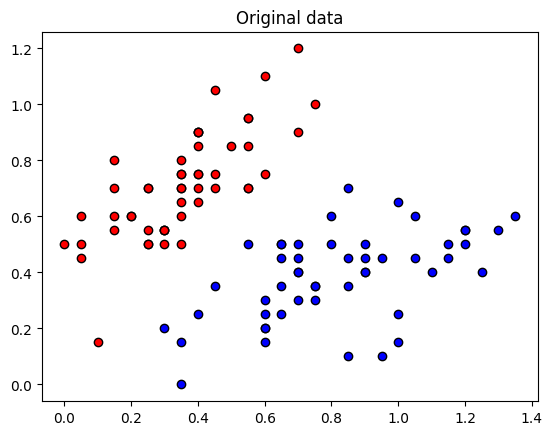

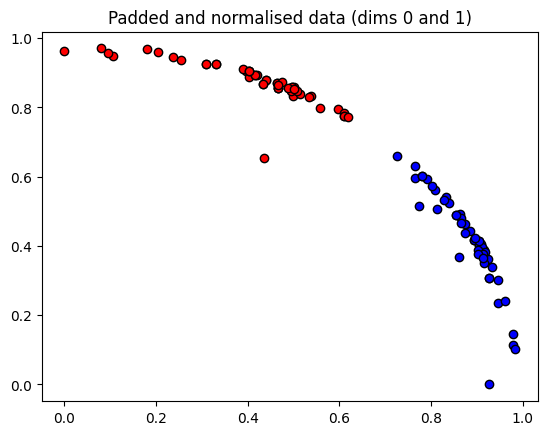

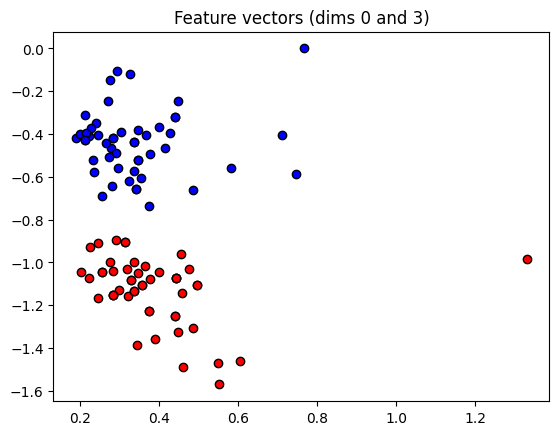

In [20]:
plt.figure()
plt.scatter(X[:, 0][Y == 1], X[:, 1][Y == 1], c="b", marker="o", ec="k")
plt.scatter(X[:, 0][Y == -1], X[:, 1][Y == -1], c="r", marker="o", ec="k")
plt.title("Original data")
plt.show()

plt.figure()
dim1 = 0
dim2 = 1
plt.scatter(X_norm[:, dim1][Y == 1], X_norm[:, dim2][Y == 1], c="b", marker="o", ec="k")
plt.scatter(X_norm[:, dim1][Y == -1], X_norm[:, dim2][Y == -1], c="r", marker="o", ec="k")
plt.title(f"Padded and normalised data (dims {dim1} and {dim2})")
plt.show()

plt.figure()
dim1 = 0
dim2 = 3
plt.scatter(features[:, dim1][Y == 1], features[:, dim2][Y == 1], c="b", marker="o", ec="k")
plt.scatter(features[:, dim1][Y == -1], features[:, dim2][Y == -1], c="r", marker="o", ec="k")
plt.title(f"Feature vectors (dims {dim1} and {dim2})")
plt.show()


In [21]:
np.random.seed(0)
num_data = len(Y)
num_train = int(0.75 * num_data)
index = np.random.permutation(range(num_data))
feats_train = features[index[:num_train]]
Y_train = Y[index[:num_train]]
feats_val = features[index[num_train:]]
Y_val = Y[index[num_train:]]

# We need these later for plotting
X_train = X[index[:num_train]]
X_val = X[index[num_train:]]


In [22]:
num_qubits = 2
num_layers = 6

weights_init = 0.01 * np.random.randn(num_layers, num_qubits, 3, requires_grad=True)
bias_init = np.array(0.0, requires_grad=True)

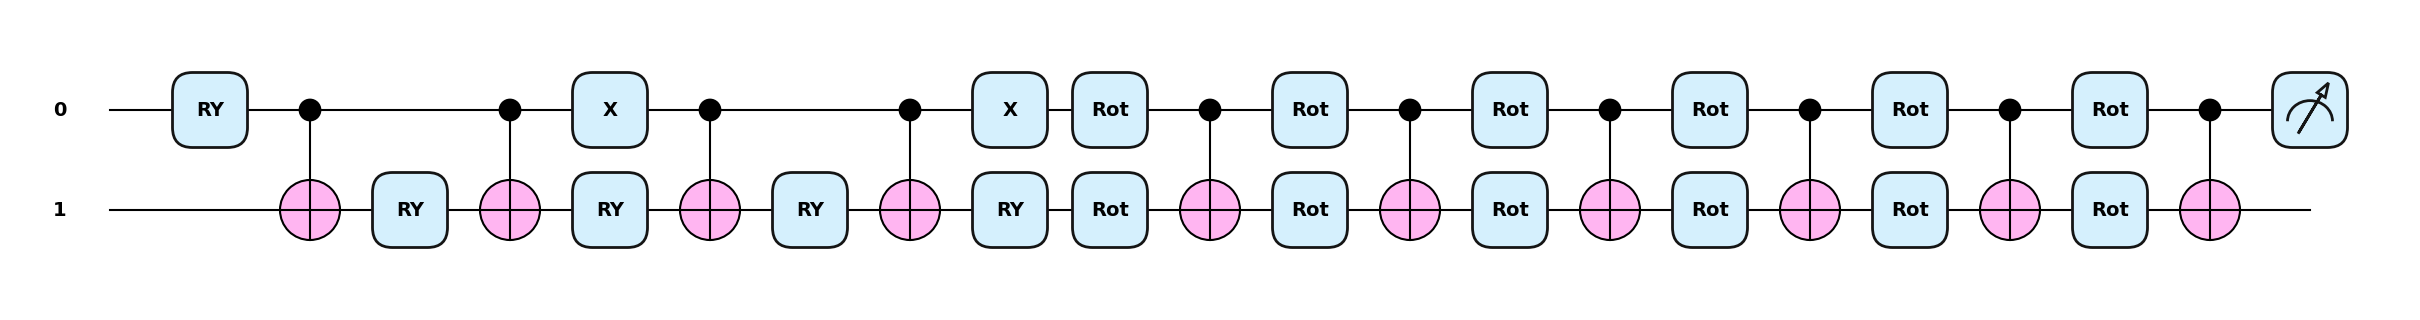

In [23]:
qml.draw_mpl(circuit, style="pennylane")(weights_init, feats_val[0])
plt.show()

In [24]:
opt = NesterovMomentumOptimizer(0.01)
batch_size = 5

# train the variational classifier
weights = weights_init
bias = bias_init
for it in range(60):
    # Update the weights by one optimizer step
    batch_index = np.random.randint(0, num_train, (batch_size,))
    feats_train_batch = feats_train[batch_index]
    Y_train_batch = Y_train[batch_index]
    weights, bias, _, _ = opt.step(cost, weights, bias, feats_train_batch, Y_train_batch)

    # Compute predictions on train and validation set
    predictions_train = np.sign(variational_classifier(weights, bias, feats_train.T))
    predictions_val = np.sign(variational_classifier(weights, bias, feats_val.T))

    # Compute accuracy on train and validation set
    acc_train = accuracy(Y_train, predictions_train)
    acc_val = accuracy(Y_val, predictions_val)

    if (it + 1) % 2 == 0:
        _cost = cost(weights, bias, features, Y)
        print(
            f"Iter: {it + 1:5d} | Cost: {_cost:0.7f} | "
            f"Acc train: {acc_train:0.7f} | Acc validation: {acc_val:0.7f}"
        )


Iter:     2 | Cost: 1.6589456 | Acc train: 0.4800000 | Acc validation: 0.5600000
Iter:     4 | Cost: 1.2054273 | Acc train: 0.4933333 | Acc validation: 0.5600000
Iter:     6 | Cost: 0.9740740 | Acc train: 0.4933333 | Acc validation: 0.7200000
Iter:     8 | Cost: 0.9660872 | Acc train: 0.6400000 | Acc validation: 0.6400000
Iter:    10 | Cost: 0.9569019 | Acc train: 0.6000000 | Acc validation: 0.6000000
Iter:    12 | Cost: 0.9445863 | Acc train: 0.4933333 | Acc validation: 0.7200000
Iter:    14 | Cost: 1.0339978 | Acc train: 0.4800000 | Acc validation: 0.5600000
Iter:    16 | Cost: 1.0774217 | Acc train: 0.4933333 | Acc validation: 0.5600000
Iter:    18 | Cost: 0.9984426 | Acc train: 0.4800000 | Acc validation: 0.5600000
Iter:    20 | Cost: 0.8975279 | Acc train: 0.5600000 | Acc validation: 0.7600000
Iter:    22 | Cost: 0.8451699 | Acc train: 0.6400000 | Acc validation: 0.6400000
Iter:    24 | Cost: 0.8337489 | Acc train: 0.5600000 | Acc validation: 0.5200000
Iter:    26 | Cost: 0.783202

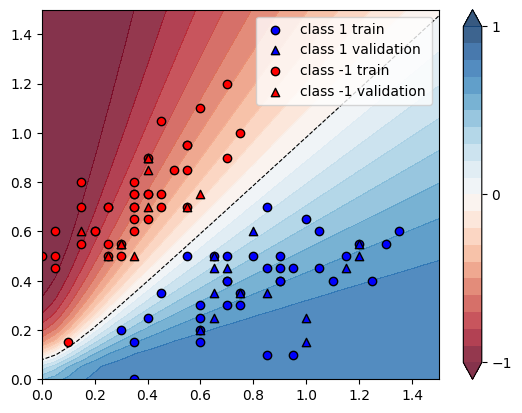

In [25]:
plt.figure()
cm = plt.cm.RdBu

# make data for decision regions
xx, yy = np.meshgrid(np.linspace(0.0, 1.5, 30), np.linspace(0.0, 1.5, 30))
X_grid = [np.array([x, y]) for x, y in zip(xx.flatten(), yy.flatten())]

# preprocess grid points like data inputs above
padding = 0.1 * np.ones((len(X_grid), 2))
X_grid = np.c_[X_grid, padding]  # pad each input
normalization = np.sqrt(np.sum(X_grid**2, -1))
X_grid = (X_grid.T / normalization).T  # normalize each input
features_grid = np.array([get_angles(x) for x in X_grid])  # angles are new features
predictions_grid = variational_classifier(weights, bias, features_grid.T)
Z = np.reshape(predictions_grid, xx.shape)

# plot decision regions
levels = np.arange(-1, 1.1, 0.1)
cnt = plt.contourf(xx, yy, Z, levels=levels, cmap=cm, alpha=0.8, extend="both")
plt.contour(xx, yy, Z, levels=[0.0], colors=("black",), linestyles=("--",), linewidths=(0.8,))
plt.colorbar(cnt, ticks=[-1, 0, 1])

# plot data
for color, label in zip(["b", "r"], [1, -1]):
    plot_x = X_train[:, 0][Y_train == label]
    plot_y = X_train[:, 1][Y_train == label]
    plt.scatter(plot_x, plot_y, c=color, marker="o", ec="k", label=f"class {label} train")
    plot_x = (X_val[:, 0][Y_val == label],)
    plot_y = (X_val[:, 1][Y_val == label],)
    plt.scatter(plot_x, plot_y, c=color, marker="^", ec="k", label=f"class {label} validation")

plt.legend()
plt.show()
